In [1]:
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.__version__

'2.10.0'

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17938054696615326888
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 30693620480
locality {
  bus_id: 1
}
incarnation: 3930926314387216244
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data and analysis

In [22]:
data = pd.read_csv('C:/Users/26022/Desktop/Deep Learning Fund/A2/digit-recognizer/train.csv')
print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split dataset

In [8]:
train_data = data.head(37800)    #split dataset to training set & validation set
val_data = data.tail(4200)

train_labels = train_data.pop('label')
val_labels = val_data.pop('label')

In [9]:
tf_train_data = tf.data.Dataset.from_tensor_slices((train_data.values, train_labels.values))
tf_val_data = tf.data.Dataset.from_tensor_slices((val_data.values, val_labels.values))
# Tensorflow has it's own api for creating a data pipeline which makes it easier to feed the data into a Tensorflow model.

print(tf_train_data)
print(tf_val_data)

<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


## Preview of Images

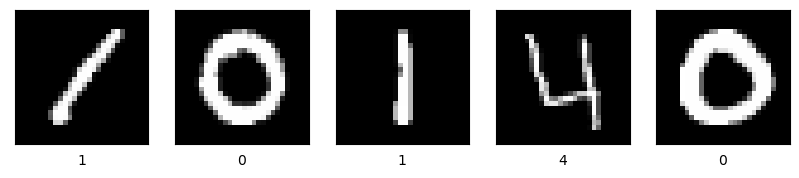

In [10]:
plt.figure(figsize=(10,10))
i = 0

for image, label in tf_train_data.take(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image.numpy().reshape((28, 28)), cmap='gray')
    plt.xlabel(label.numpy())

    i = i + 1

## Data pipeline

In [11]:
def preprocess_image(image, label):
    image = tf.reshape(image, [28, 28, 1])   # reshaped into a 3D matrix which in this case is a 28x28 matrix in channel 1 as these images are greyscale
    image = tf.cast(image, tf.float32) / 255.  #Models seem to perform better when numeric features are put onto a 0-1 scale. 
                                               #As all the features are numeric and on a 0-255 scale it is easy to put the data onto this scale by simply dividing the features by 255.
    
    return image, label

tf_train_data = tf_train_data.map(
    preprocess_image, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

tf_val_data = tf_val_data.map(
    preprocess_image, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

print(tf_train_data)
print(tf_val_data)

<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [12]:
def pipeline(tf_data):
    tf_data = tf_data.shuffle(100)  #To make sure the model doesn't pick up anything from the order of the rows in the dataset
    tf_data = tf_data.batch(32)   #To ensure the processor doesn't get overloaded, the data will be fed in 32 images at a time
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)  #When the current step ends there is no time wasted loading the next batch as it is ready to go
    
    return tf_data

tf_train_data = pipeline(tf_train_data)
tf_val_data = pipeline(tf_val_data)

print(tf_train_data)
print(tf_val_data)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


## Train model

In [13]:
#Modified LeNet-5 architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    
    tf.keras.layers.Dense(10, activation='softmax'),
])

In [14]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimiser, 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [15]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [16]:
train_log = model.fit(
    tf_train_data,
    validation_data=tf_val_data,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
1182/1182 [==============================] - 6s 4ms/step - loss: 0.2375 - accuracy: 0.9255 - val_loss: 0.0900 - val_accuracy: 0.9724 - lr: 0.0010
Epoch 2/50
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0737 - accuracy: 0.9778 - val_loss: 0.0798 - val_accuracy: 0.9776 - lr: 0.0010
Epoch 3/50
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0512 - accuracy: 0.9847 - val_loss: 0.0612 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 4/50
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0404 - accuracy: 0.9876 - val_loss: 0.0649 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 5/50
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0313 - accuracy: 0.9905 - val_loss: 0.0510 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 6/50
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0267 - accuracy: 0.9912 - val_loss: 0.0891 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 7/50
1182/1182 [==============================] - 5s

1182/1182 [==============================] - 5s 4ms/step - loss: 1.0927e-05 - accuracy: 1.0000 - val_loss: 0.0517 - val_accuracy: 0.9910 - lr: 1.0000e-13
Epoch 42/50
1178/1182 [============================>.] - ETA: 0s - loss: 1.0923e-05 - accuracy: 1.0000
Epoch 42: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.
1182/1182 [==============================] - 5s 4ms/step - loss: 1.0927e-05 - accuracy: 1.0000 - val_loss: 0.0517 - val_accuracy: 0.9910 - lr: 1.0000e-13
Epoch 43/50
1182/1182 [==============================] - 5s 4ms/step - loss: 1.0927e-05 - accuracy: 1.0000 - val_loss: 0.0517 - val_accuracy: 0.9910 - lr: 1.0000e-14
Epoch 44/50
1173/1182 [============================>.] - ETA: 0s - loss: 1.0966e-05 - accuracy: 1.0000
Epoch 44: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
1182/1182 [==============================] - 5s 4ms/step - loss: 1.0927e-05 - accuracy: 1.0000 - val_loss: 0.0517 - val_accuracy: 0.9910 - lr: 1.0000e-14
Epoch 45/5

## Accuracy Plot and Validation test

Training accuracy: 1.000000
Validation accuracy: 0.990952


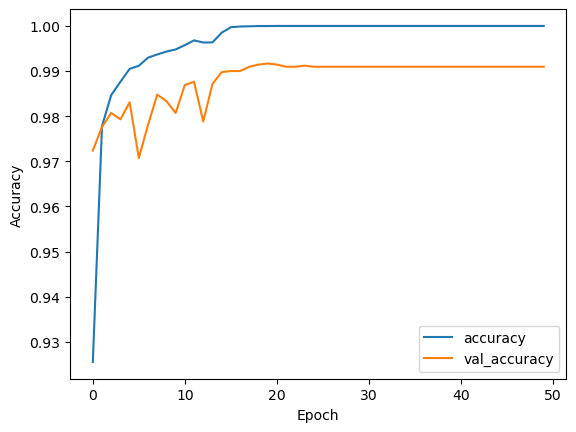

In [17]:
plt.plot(train_log.history['accuracy'], label='accuracy')
plt.plot(train_log.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print('Training accuracy: %f' % train_log.history['accuracy'][-1])
print('Validation accuracy: %f' % train_log.history['val_accuracy'][-1])

In [18]:
test_data = pd.read_csv('C:/Users/26022/Desktop/Deep Learning Fund/A2/digit-recognizer/test.csv')
tf_test_data = tf.data.Dataset.from_tensor_slices(([test_data.to_numpy().reshape(len(test_data), 28, 28, 1)]))

In [19]:
predictions = model.predict(tf_test_data)
predictions = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 314ms/step


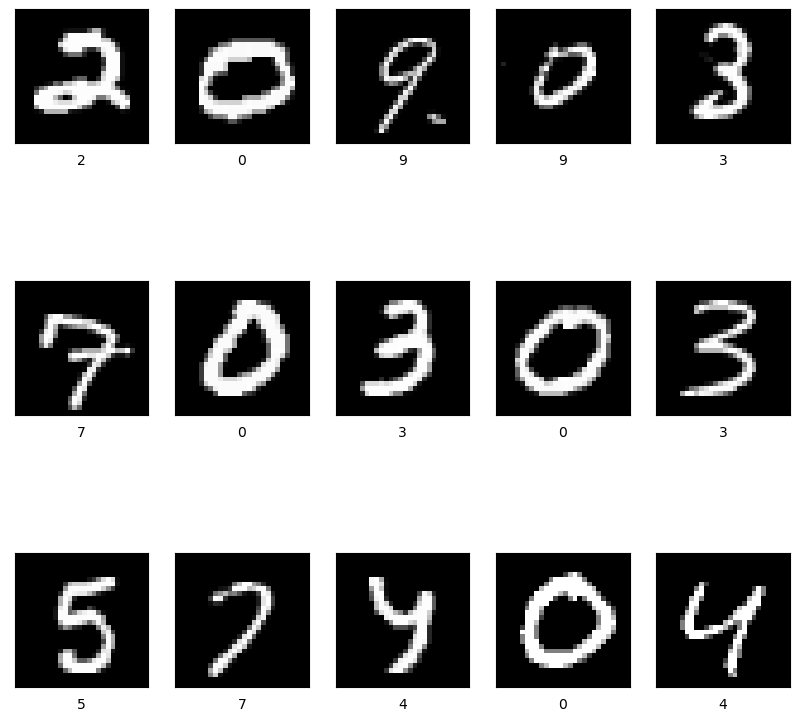

In [20]:
plt.figure(figsize=(10,10))

for i, row in test_data.head(15).iterrows():
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(row.values.reshape((28, 28)), cmap='gray')
    plt.xlabel(predictions[i])